### predict path/benign w/ mpc score
* hold out one gene at a time
* eval on just domains looks very bad for my score
* nn and decision tree do not help

In [108]:
import pandas, pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, tree
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from IPython.display import HTML
%matplotlib inline

In [105]:
#!pip install pydot
#!pip install pydotplus
#!pip install graphviz
!conda install graphviz -y

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /opt/conda:

The following NEW packages will be INSTALLED:

    expat:    2.1.0-0     
    graphviz: 2.38.0-5    
    libtool:  2.4.2-0     

The following packages will be UPDATED:

    conda:    4.3.9-py34_0 --> 4.3.25-py34_0

expat-2.1.0-0. 100% |################################| Time: 0:00:00   4.02 MB/s
libtool-2.4.2- 100% |################################| Time: 0:00:00   5.10 MB/s
conda-4.3.25-p 100% |################################| Time: 0:00:00   4.95 MB/s
graphviz-2.38. 100% |################################| Time: 0:00:02   4.89 MB/s


In [143]:
# hidden_layer_sizes=(2,1,)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    random_state=1)
tree_clf = tree.DecisionTreeClassifier(max_depth=3)

In [145]:
f = '../data/interim/sig_flagged/EPIv6.eff.dbnsfp.anno.hHack.splitPfam.all.dat'
df_pre = pandas.read_csv(f, delimiter='\t')

# not VUS, and mpc needs to be available
df = df_pre[ (df_pre.clin_class != 'VUS') & (df_pre.mpc>0) & (df_pre.pfam!='none')]
df.loc[:, 'none_domain'] = df.apply(lambda row: row['pfam']=='none', axis=1)
df.loc[:, 'is_sig'] = df.apply(lambda row: 1 if row['all_qval']<.01 else 0, axis=1)
df.loc[:, 'y'] = df.apply(lambda row: 1 if row['clin_class'] in ('PATHOGENIC', 'LIKLEY_PATHOGENIC')
                          else 0, axis=1)
df.loc[:, 'fg_gtr'] = df.apply(lambda row: 1 if row['all_fg_gtr'] else 0, axis=1)
df.loc[:, 'exac:fg'] = (df['all_bg']/df['all_bgtot']) / (df['all_fg']/df['all_fgtot'])
df.loc[:, 'fg_frac'] = df['all_fg']/df['all_fgtot']
df.loc[:, 'bg_frac'] = df['all_bg']/df['all_bgtot']
genes = set(df['gene'])
df.head()

/opt/conda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,...,all_bgtot,all_fg_gtr,all_qval,none_domain,is_sig,y,fg_gtr,exac:fg,fg_frac,bg_frac
6,1,40542572,T,C,PATHOGENIC,Palm_thioest:3,0.000000,missense_variant,2,8544,...,1062100.0,True,0.043341,False,0,1,1,0.225658,0.000058,0.000013
16,1,40555089,G,C,PATHOGENIC,Palm_thioest:6,0.000000,missense_variant,1,8544,...,4885660.0,False,0.053245,False,0,1,0,2.029511,0.000032,0.000065
17,1,40555089,G,C,PATHOGENIC,Palm_thioest:7,0.000000,missense_variant,1,8544,...,4885660.0,False,0.053245,False,0,1,0,2.029511,0.000032,0.000065
22,1,40557070,T,A,PATHOGENIC,Palm_thioest:9,0.000599,missense_variant,2,8543,...,2124152.0,False,0.000233,False,1,1,0,5.124508,0.000023,0.000120
24,1,40557754,A,C,PATHOGENIC,Palm_thioest:10,0.000000,missense_variant,1,8544,...,2549040.0,True,0.799538,False,0,1,1,0.789145,0.000032,0.000025


In [55]:
df.groupby(['gene', 'y']).size()

gene      y
ALDH7A1   0     4
          1    14
ARX       1     1
ATP1A2    0     4
          1     4
ATP6AP2   0     2
CACNB4    0     2
CDKL5     0     2
          1    32
CHRNA2    0     9
CHRNA4    0    12
          1     2
CHRNB2    0     7
          1     2
CLN3      0     6
          1     1
CNTNAP2   0    15
CSTB      0     3
CTSD      0     3
          1     2
EFHC1     0     1
EPM2A     1     1
FOLR1     0     2
GABRA1    1     8
GABRG2    1    11
GOSR2     0     1
GRIN2A    0     1
          1     7
GRIN2B    1     1
KCNJ10    0     3
               ..
PNKP      0     3
          1     2
PNPO      1     1
POLG      0     5
          1    27
PPT1      0     1
          1     7
PRICKLE1  0     1
SCARB2    0     3
SCN1A     1    87
SCN1B     0     2
          1     7
SCN2A     0     2
          1    44
SCN8A     1    13
SLC25A22  0     9
SLC2A1    1    50
SLC9A6    0     1
          1     1
SPTAN1    0    41
          1     2
SRPX2     0     3
STXBP1    0     6
          1    1

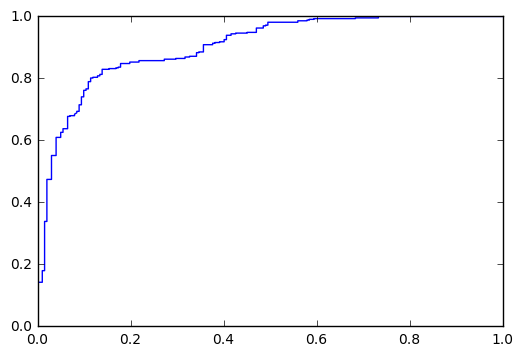

In [56]:
scores = df['mpc'].values
truth = df['y'].values
fpr_mpc, tpr_mpc, _ = metrics.roc_curve(truth, scores, pos_label=1)
#pre, rec, thresh_pr = metrics.precision_recall_curve(truth, scores, pos_label=1)
plt.plot(fpr_mpc, tpr_mpc)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c382da080>]], dtype=object)

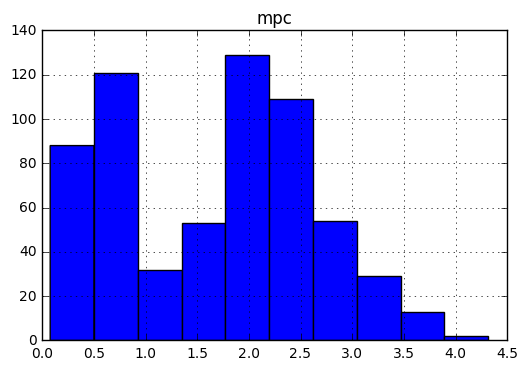

In [57]:
df.hist(column='mpc')

In [146]:
# nn
all_preds = []
all_truth = []
# all_qval, 'none_domain', is_sig
cols = ['mpc', 'fg_gtr', 'all_qval', 'is_sig', 'exac:fg', 'all_fg', 'all_bg', 'fg_frac', 'bg_frac']
for gene in genes:
    df_train = df[df.gene!=gene]
    df_test = df[df.gene==gene]
    X, y = df_train[cols], df_train['y']
    clf.fit(X, y)
    X_test, y_test = df_test[cols], df_test['y']
    preds = clf.predict_proba(X_test)
    preds_simple = clf.predict(X_test)
    tot, good = 0,0
    for pred, pred_s, truth in zip(preds, preds_simple, y_test):
        all_preds.append(pred[1])
        all_truth.append(truth)
        tot += 1
        if pred_s==truth:
            good += 1
    #print(gene, tot, good, good/tot)
fpr, tpr, _ = metrics.roc_curve(all_truth, all_preds, pos_label=1)
#plt.plot(fpr, tpr)       

In [152]:
# decision tree
all_preds = []
all_truth = []
cols = ['mpc', 'fg_gtr', 'all_qval', 'is_sig', 'exac:fg', 'fg_frac', 'bg_frac', 'all_fg', 'all_bg']
for gene in genes:
    df_train = df[df.gene!=gene]
    df_test = df[df.gene==gene]
    X, y = df_train[cols], df_train['y']
    tree_clf.fit(X, y)
    dot_data = StringIO()
    tree.export_graphviz(tree_clf, feature_names=cols, out_file=dot_data)
    graph = pydotplus.graph_from_dot_data( dot_data.getvalue() )
    graph.write_pdf('mtr_tree.%s.pdf' % (gene,))
    X_test, y_test = df_test[cols], df_test['y']
    preds = tree_clf.predict_proba(X_test)
    preds_simple = tree_clf.predict(X_test)
    tot, good = 0,0
    for pred, pred_s, truth in zip(preds, preds_simple, y_test):
        all_preds.append(pred[1])
        all_truth.append(truth)
        tot += 1
        if pred_s==truth:
            good += 1
    #print(gene, tot, good, good/tot)
fpr_tree, tpr_tree, _ = metrics.roc_curve(all_truth, all_preds, pos_label=1)

In [149]:
HTML('<iframe src=./mtr_tree.ALDH7A1.pdf width=1000 height=500></iframe>')

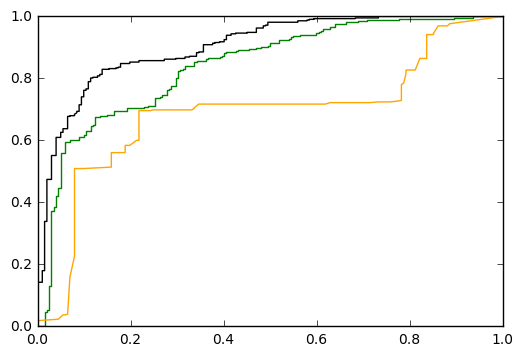

In [153]:
plt.plot(fpr_mpc, tpr_mpc, label='mpc', color='black')
plt.plot(fpr, tpr, label='nn', color='green')
plt.plot(fpr_tree, tpr_tree, label='tree', color='orange')

In [60]:
df.groupby(['gene','pfam','y']).size()

gene     pfam               y
ALDH7A1  Aldedh:172         0     2
         Aldedh:173         1     2
         Aldedh:177         1     5
         Aldedh:178         1     5
         Aldedh:182         0     2
         Aldedh:188         1     2
ARX      Homeobox:423       1     1
ATP1A2   Cation_ATPase_C:8  1     1
         Cation_ATPase_C:9  1     1
         Cation_ATPase_N:6  0     1
         E1-E2_ATPase:12    0     1
         E1-E2_ATPase:13    0     1
         Hydrolase:25       1     2
         Hydrolase:29       0     1
ATP6AP2  Renin_r:1          0     1
         Renin_r:2          0     1
CACNB4   Ca_channel_B:33    0     1
         Ca_channel_B:34    0     1
CDKL5    Pkinase:3571       1     1
         Pkinase:3572       1     1
         Pkinase:3573       1     1
         Pkinase:3574       1     5
         Pkinase:3575       1     4
         Pkinase:3576       0     1
                            1     4
         Pkinase:3577       1     3
         Pkinase:3579       1     